## Evaluating EfficientNet and ResNet18 on German Traffic Sign Dataset
### Billy Ryan

### Outline:
- Run final models (EfficientNet and ResNet18) on test set
- Compute basic statistics / visualisation and make inferences
- Observe statistics over all classes to identify trends
- Check common misclassified images in individual models and in both models
- Compute image process time of models and make inferences
- Draw conclusions given findings
- Link to further study and reference other sections of the project

We begin our evaluation with importing functions from previous sections (see Neva and Gracie's work, and my previous files).

In [60]:
# import all required libraries for this evaluation script
import os
import numpy as np
import pandas as pd
from pathlib import Path
import kagglehub
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image, ImageEnhance
import math
from typing import List, Tuple
from collections import Counter
import seaborn as sns
import torch
from torchvision import transforms
from torchvision.models import EfficientNet_B0_Weights
from torchvision.models import efficientnet_b0
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time

In [44]:
# Download latest version of the dataset and follow procedure in initial file
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

test_df_path =  os.path.join(path, "Test.csv")
test_img_path =  os.path.join(path, "Test")
test_df = pd.read_csv(test_df_path)

class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

test_df["ClassName"] = test_df['ClassId'].map(class_names)

In [45]:
# make sure we are in the project directory to call upon mdodels and data correctly
os.chdir("C:/Users/billy/DataScienceToolbox-Project2")
print(os.getcwd())

C:\Users\billy\DataScienceToolbox-Project2


In [46]:
# define normalization constants for imagenet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# test transform (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [47]:
# custom dataset class
class GTSRBDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = Path(root_dir)      # <-- convert to Path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.root_dir / row["Path"]   # Path object
        img = Image.open(img_path).convert("RGB")
        label = int(row["ClassId"])

        if self.transform:
            img = self.transform(img)
        return img, label

# create test dataset and dataloader
test_dataset = GTSRBDataset(test_df, root_dir=path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [48]:
NUM_CLASSES = 43

# Load EfficientNet base model
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
base_model = efficientnet_b0(weights=weights)

# remove classifier
base_model.classifier = nn.Identity()

# freeze base model
for param in base_model.parameters():
    param.requires_grad = False

# build the full model
model_eff = nn.Sequential(
    base_model,                # (0)
    nn.Linear(1280, 256),      # (2)
    nn.ReLU(),                 # (3)
    nn.Dropout(0.4),           # (4)
    nn.Linear(256, NUM_CLASSES),  # (5)
    nn.Softmax(dim=1)          # (6)
)

# load the saved weights
state_dict = torch.load("Neva/efficientnet_best.pth", map_location="cpu")
model_eff.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model_resnet18 = models.resnet18(weights=None)
model_resnet18.fc = torch.nn.Linear(512, 43)   # example for 43 traffic signs
state_dict_resnet18 = torch.load("Gracie/resnet18_best.pth", map_location="cpu")
model_resnet18.load_state_dict(state_dict_resnet18)

FileNotFoundError: [Errno 2] No such file or directory: 'Gracie/resnet18_best_finetuned.pth'

In [8]:
# require these for later cells
class_names = test_loader.dataset.class_names if hasattr(test_loader.dataset, 'class_names') else class_names
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Below, we finally train our models using the weights that Neva and Gracie found for their respective models. This cell may take some time to run but will output the accuracy and loss of the models.

In [11]:
model_eff.to(device)            
model_resnet18.to(device)
criterion = nn.CrossEntropyLoss()

# Initialize metrics
correct_eff = correct_res = top5_correct_eff = top5_correct_res = total = 0
running_loss_eff = running_loss_res = 0.0
all_labels, all_pred_eff, all_pred_res = [], [], []

model_eff.eval()
model_resnet18.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = labels.size(0)
        
        # EfficientNet
        outputs_eff = model_eff(images)
        _, pred_eff = torch.max(outputs_eff, 1)
        _, top5_eff = torch.topk(outputs_eff, 5, dim=1)
        correct_eff += (pred_eff == labels).sum().item()
        top5_correct_eff += (top5_eff == labels.unsqueeze(1)).any(dim=1).sum().item()
        running_loss_eff += criterion(outputs_eff, labels).item() * batch_size
        
        # ResNet18
        outputs_res = model_resnet18(images)
        _, pred_res = torch.max(outputs_res, 1)
        _, top5_res = torch.topk(outputs_res, 5, dim=1)
        correct_res += (pred_res == labels).sum().item()
        top5_correct_res += (top5_res == labels.unsqueeze(1)).any(dim=1).sum().item()
        running_loss_res += criterion(outputs_res, labels).item() * batch_size
        
        # store predictions
        total += batch_size
        all_labels.append(labels.cpu().numpy())
        all_pred_eff.append(pred_eff.cpu().numpy())
        all_pred_res.append(pred_res.cpu().numpy())

# calculate desired metrics (test accuracy, top-5 accuracy, avg loss)
accuracy_eff = 100 * correct_eff / total
top5_accuracy_eff = 100 * top5_correct_eff / total
avg_loss_eff = running_loss_eff / total

accuracy_res = 100 * correct_res / total
top5_accuracy_res = 100 * top5_correct_res / total
avg_loss_res = running_loss_res / total

print(f"Test Accuracy for EfficientNet: {accuracy_eff:.2f}%  | Top-5: {top5_accuracy_eff:.2f}% | Loss: {avg_loss_eff:.4f}")
print(f"Test Accuracy for ResNet18:     {accuracy_res:.2f}%  | Top-5: {top5_accuracy_res:.2f}% | Loss: {avg_loss_res:.4f}")

# need for further analysis
y_true = np.concatenate(all_labels)
y_pred_eff = np.concatenate(all_pred_eff)
y_pred_res = np.concatenate(all_pred_res)

Test Accuracy for EfficientNet: 74.15%  | Top-5: 94.75% | Loss: 3.1044
Test Accuracy for ResNet18:     68.36%  | Top-5: 93.56% | Loss: 1.0516


Talk about accuracy, top-5 and loss here:
[1] https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html, [2] https://www.datacamp.com/tutorial/loss-function-in-machine-learning

Now we wish to look at measures such as precision, accuracy and f1-score. TALK ABOUT THEM HERE....

Below is a function that will output a classification report, which contains our desired metrics, allowing us to compute useful plots and make inferences about the models.

In [12]:
def classification_report_model(model, test_loader, device):
    model.to(device).eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())
    
    report_dict = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
    df_metrics = pd.DataFrame(report_dict).transpose()
    
    return df_metrics, all_labels, all_preds

In [13]:
df_effnet, true_effnet, pred_effnet = classification_report_model(model_eff, test_loader, device)
cm = confusion_matrix(true_effnet, pred_effnet)
print(df_effnet)

              precision    recall  f1-score       support
0              0.625000  0.083333  0.147059     60.000000
1              0.739938  0.663889  0.699854    720.000000
2              0.557100  0.748000  0.638589    750.000000
3              0.620843  0.622222  0.621532    450.000000
4              0.715543  0.739394  0.727273    660.000000
5              0.662669  0.701587  0.681573    630.000000
6              0.876033  0.706667  0.782288    150.000000
7              0.914141  0.804444  0.855792    450.000000
8              0.748889  0.748889  0.748889    450.000000
9              0.870824  0.814583  0.841765    480.000000
10             0.875193  0.860606  0.867838    660.000000
11             0.684760  0.780952  0.729700    420.000000
12             0.985871  0.910145  0.946496    690.000000
13             0.796400  0.983333  0.880050    720.000000
14             0.980695  0.940741  0.960302    270.000000
15             0.939086  0.880952  0.909091    210.000000
16            

In [14]:
df_resnet, true_resnet, pred_resnet = classification_report_model(model_resnet18, test_loader, device)
cm_resnet = confusion_matrix(true_resnet, pred_resnet)
print(df_resnet)

              precision    recall  f1-score      support
0              0.215686  0.183333  0.198198     60.00000
1              0.640648  0.604167  0.621873    720.00000
2              0.479582  0.673333  0.560177    750.00000
3              0.424947  0.446667  0.435536    450.00000
4              0.781302  0.709091  0.743447    660.00000
5              0.620214  0.642857  0.631333    630.00000
6              0.907692  0.786667  0.842857    150.00000
7              0.760976  0.693333  0.725581    450.00000
8              0.710396  0.637778  0.672131    450.00000
9              0.776181  0.787500  0.781799    480.00000
10             0.783824  0.807576  0.795522    660.00000
11             0.762763  0.604762  0.674635    420.00000
12             0.936842  0.902899  0.919557    690.00000
13             0.989130  0.884722  0.934018    720.00000
14             0.972868  0.929630  0.950758    270.00000
15             0.952381  0.952381  0.952381    210.00000
16             0.866197  0.8200

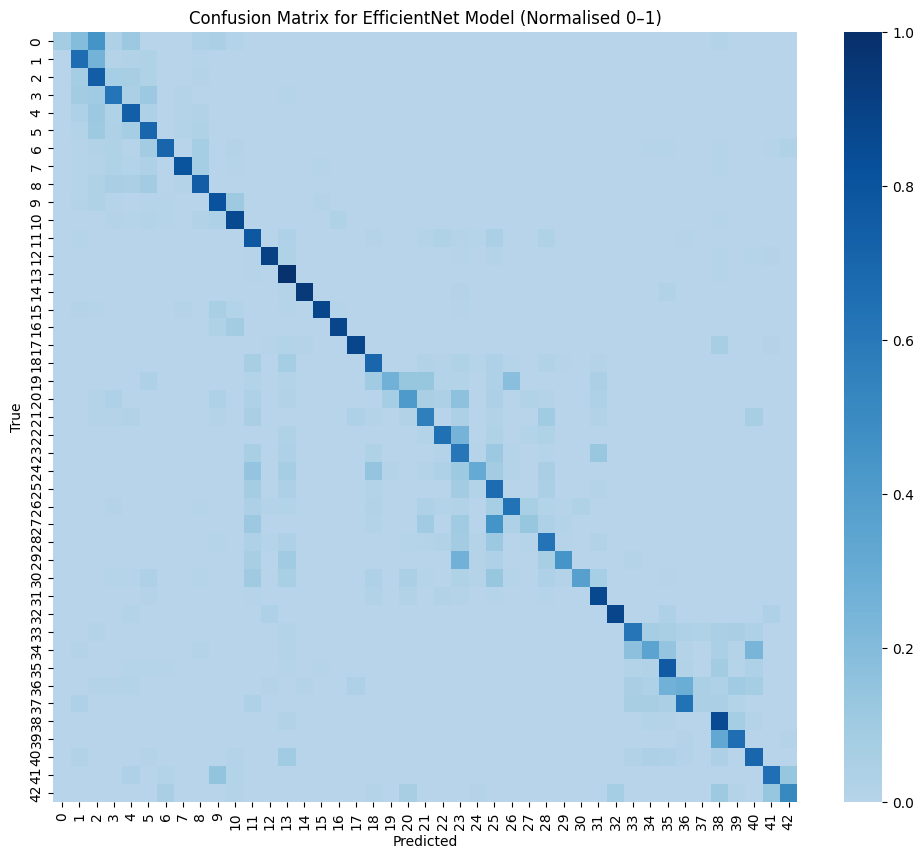

In [66]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
blues = plt.cm.Blues
new_blues = LinearSegmentedColormap.from_list("clippedBlues",  blues(np.linspace(0.3, 1, 256)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, cmap=new_blues, vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for EfficientNet Model (Normalised 0–1)")
plt.show()

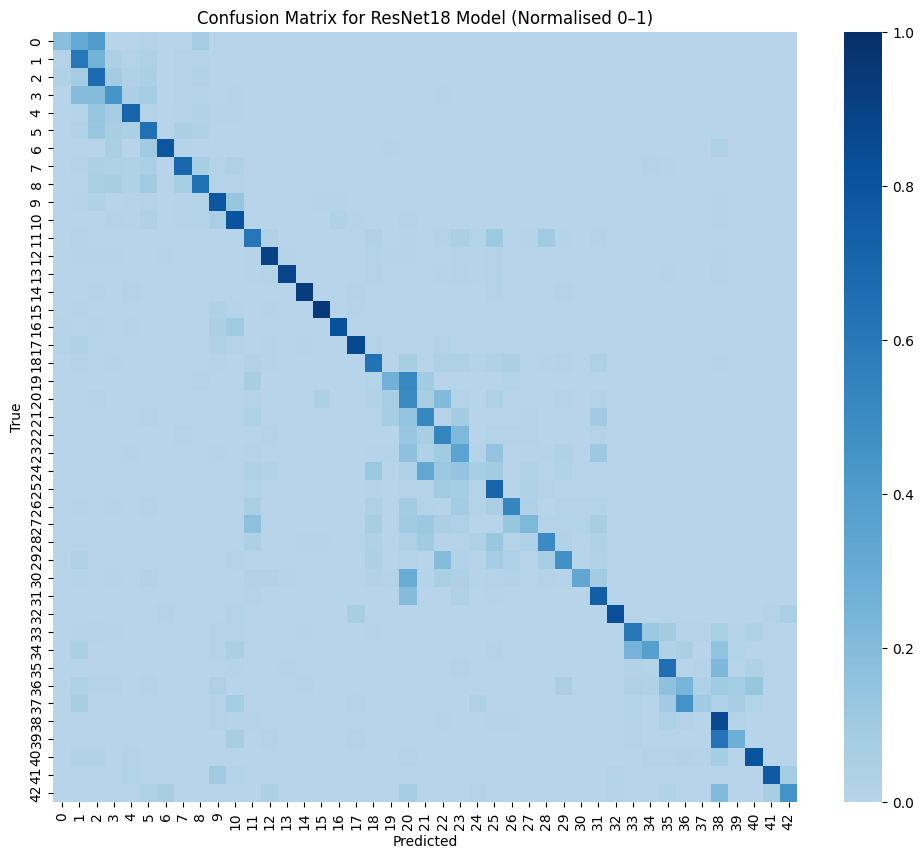

In [75]:
cm_resnet_norm = cm_resnet.astype(float) / cm_resnet.sum(axis=1, keepdims=True)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_resnet_norm, cmap=new_blues, vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for ResNet18 Model (Normalised 0–1)")
plt.show()

In [68]:
precision_eff_weighted = df_effnet.loc["weighted avg", "precision"]
recall_eff_weighted = df_effnet.loc["weighted avg", "recall"]
f1_eff_weighted = df_effnet.loc["weighted avg", "f1-score"]

precision_res_weighted = df_resnet.loc["weighted avg", "precision"]
recall_res_weighted = df_resnet.loc["weighted avg", "recall"]
f1_res_weighted = df_resnet.loc["weighted avg", "f1-score"]

print(f"EfficientNet - Macro Precision: {precision_eff_weighted:.4f}, Macro Recall: {recall_eff_weighted:.4f}, Macro F1-Score: {f1_eff_weighted:.4f}\n")
print(f"ResNet18   - Macro Precision: {precision_res_weighted:.4f}, Macro Recall: {recall_res_weighted:.4f}, Macro F1-Score: {f1_res_weighted:.4f}")

EfficientNet - Macro Precision: 0.7520, Macro Recall: 0.7415, Macro F1-Score: 0.7391

ResNet18   - Macro Precision: 0.7069, Macro Recall: 0.6836, Macro F1-Score: 0.6884


In [69]:
def show_worst_classes(df, model_name, n=5):
    worst = (df.iloc[:-3].sort_values("recall").head(n)[["precision", "recall", "f1-score", "support"]].round(3))

    print(f"\n{model_name} – {n} worst classes (by recall)\n")
    print(worst.to_string())

show_worst_classes(df_effnet, "EfficientNet")
show_worst_classes(df_resnet, "ResNet18")


EfficientNet – 5 worst classes (by recall)

    precision  recall  f1-score  support
37      0.200   0.050     0.080     60.0
0       0.625   0.083     0.147     60.0
27      0.320   0.133     0.188     60.0
19      0.640   0.267     0.376     60.0
36      0.350   0.292     0.318    120.0

ResNet18 – 5 worst classes (by recall)

    precision  recall  f1-score  support
24      0.111   0.067     0.083     90.0
37      0.286   0.100     0.148     60.0
0       0.216   0.183     0.198     60.0
27      0.283   0.217     0.245     60.0
36      0.387   0.242     0.297    120.0


Recognise common "worst" classes

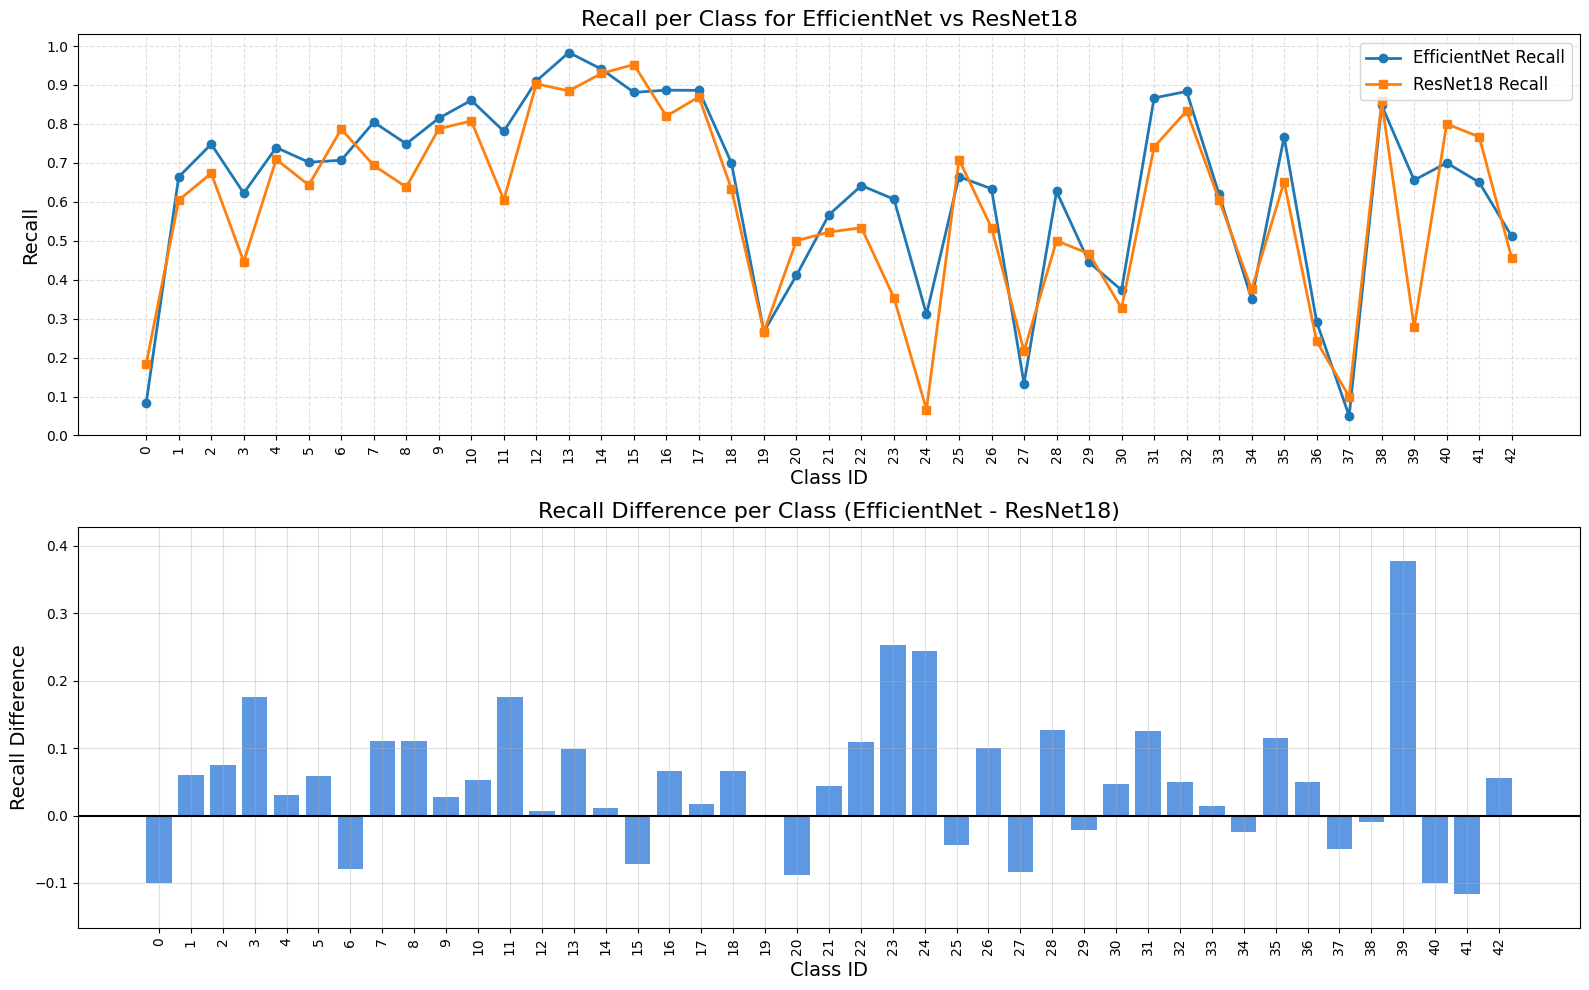

In [70]:
eff = df_effnet.iloc[:-3] 
res = df_resnet.iloc[:-3]
classes = eff.index.astype(int)

recall_eff = eff["recall"].values   # vector length 43
recall_res = res["recall"].values

diff_recall = recall_eff - recall_res

plt.figure(figsize=(16,10))

#recall plot
plt.subplot(2,1,1)
plt.plot(classes, recall_eff, marker='o', label="EfficientNet Recall", linewidth=2)
plt.plot(classes, recall_res, marker='s', label="ResNet18 Recall", linewidth=2)
plt.title("Recall per Class for EfficientNet vs ResNet18", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.xticks(classes, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)


# diff plot
plt.subplot(2,1,2)
plt.bar(classes, diff_recall, color='#5F98E2')
plt.axhline(0, color="black")
plt.ylim(min(diff_recall) - 0.05, max(diff_recall) + 0.05)
plt.title("Recall Difference per Class (EfficientNet - ResNet18)", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("Recall Difference", fontsize=14)
plt.xticks(classes, rotation=90)
plt.grid(True, alpha=0.4)


plt.tight_layout()
plt.show()

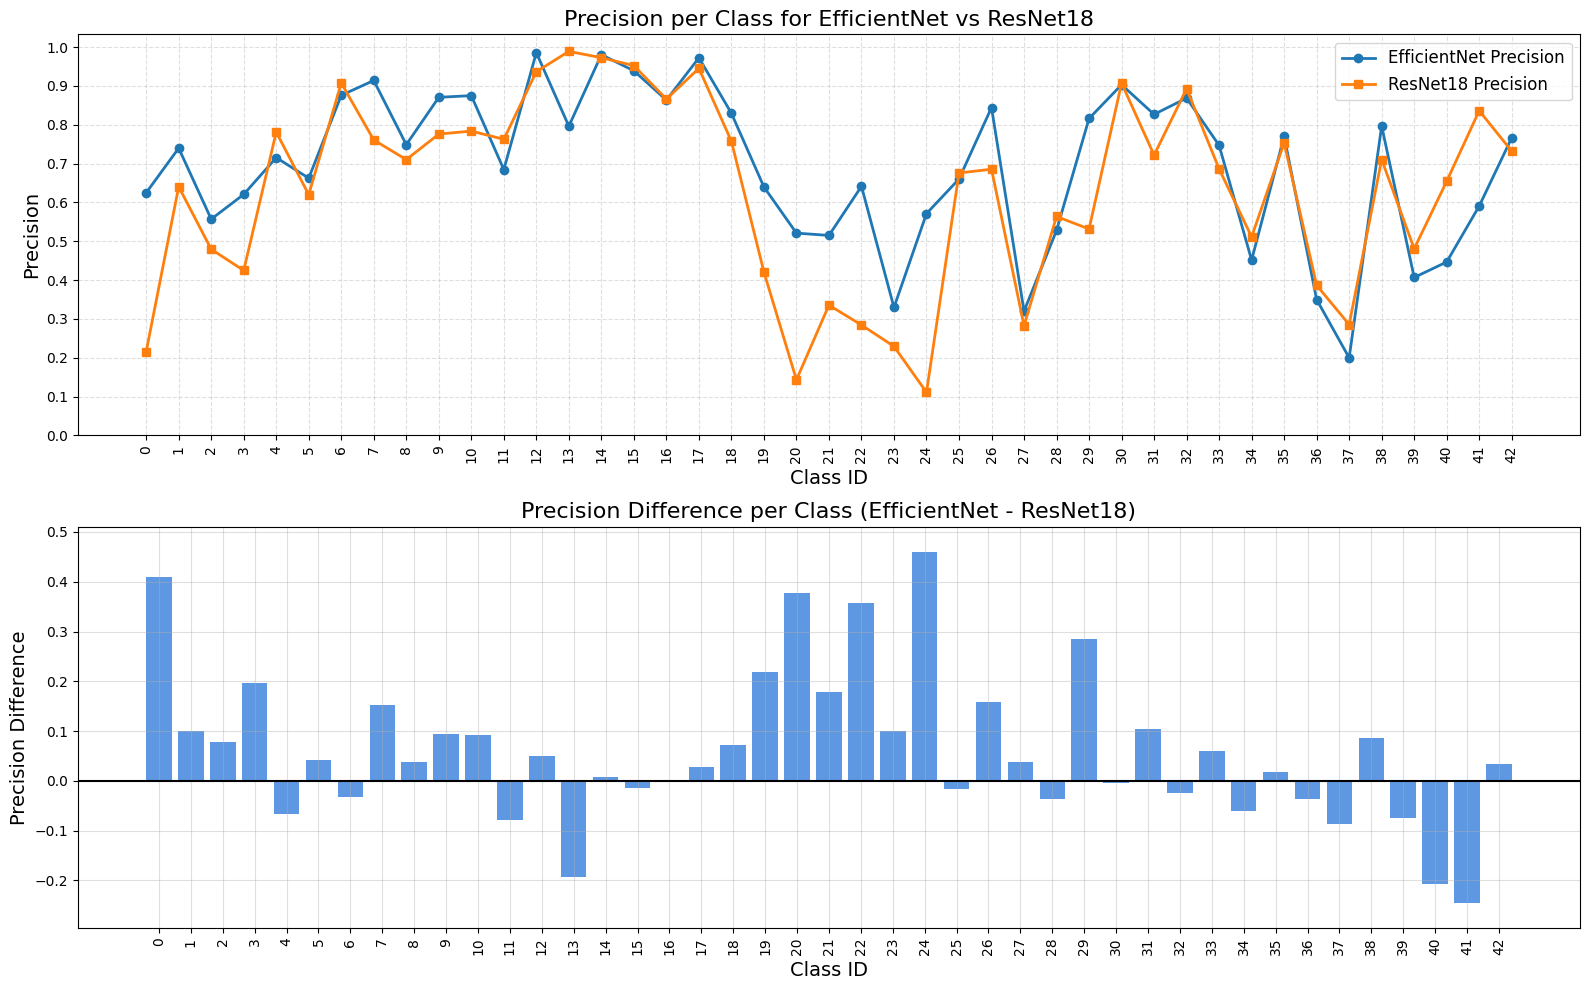

In [21]:
precision_eff = eff["precision"].values 
precision_res = res["precision"].values   
 
diff_precision = precision_eff - precision_res

plt.figure(figsize=(16,10))

#precision plot
plt.subplot(2,1,1)
plt.plot(classes, precision_eff, marker='o', label="EfficientNet Precision", linewidth=2)
plt.plot(classes, precision_res, marker='s', label="ResNet18 Precision", linewidth=2)
plt.title("Precision per Class for EfficientNet vs ResNet18", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.xticks(classes, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)


# diff plot
plt.subplot(2,1,2)
plt.bar(classes, diff_precision, color='#5F98E2')
plt.axhline(0, color="black")
plt.ylim(min(diff_precision) - 0.05, max(diff_precision) + 0.05)
plt.title("Precision Difference per Class (EfficientNet - ResNet18)", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("Precision Difference", fontsize=14)
plt.xticks(classes, rotation=90)
plt.grid(True, alpha=0.4)


plt.tight_layout()
plt.show()

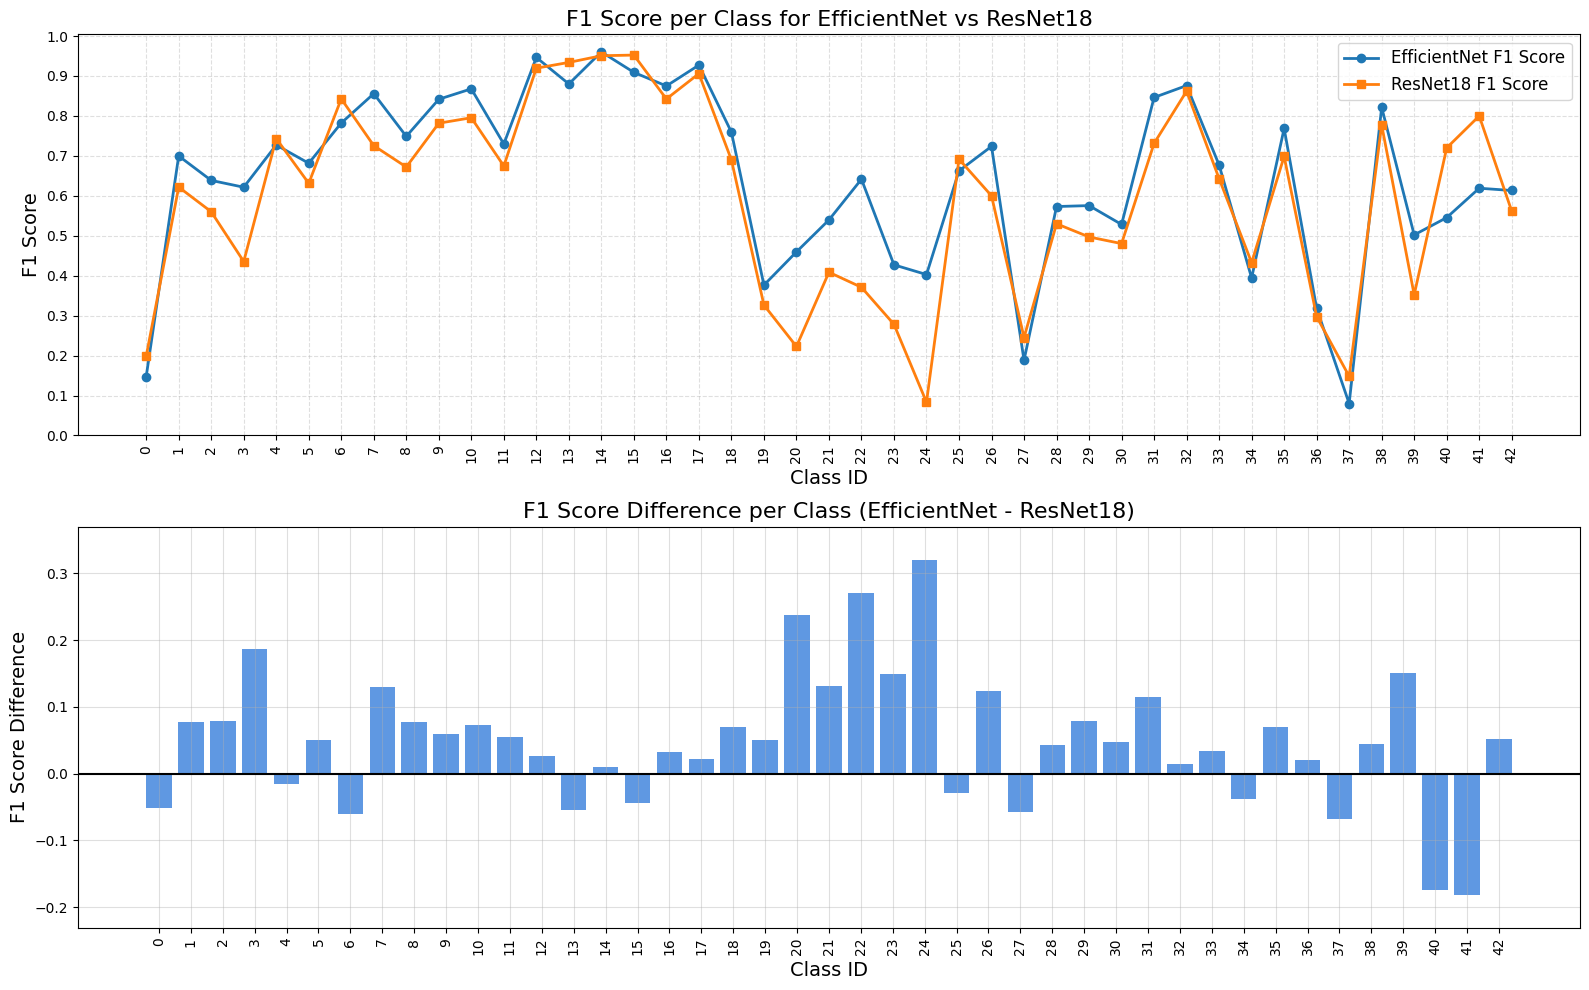

In [22]:
f1_eff = eff["f1-score"].values 
f1_res = res["f1-score"].values   
 
diff_f1 = f1_eff - f1_res

plt.figure(figsize=(16,10))

# f1 plot
plt.subplot(2,1,1)
plt.plot(classes, f1_eff, marker='o', label="EfficientNet F1 Score", linewidth=2)
plt.plot(classes, f1_res, marker='s', label="ResNet18 F1 Score", linewidth=2)
plt.title("F1 Score per Class for EfficientNet vs ResNet18", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(classes, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)


# diff plot
plt.subplot(2,1,2)
plt.bar(classes, diff_f1, color='#5F98E2')
plt.axhline(0, color="black")
plt.ylim(min(diff_f1) - 0.05, max(diff_f1) + 0.05)
plt.title("F1 Score Difference per Class (EfficientNet - ResNet18)", fontsize=16)
plt.xlabel("Class ID", fontsize=14)
plt.ylabel("F1 Score Difference", fontsize=14)
plt.xticks(classes, rotation=90)
plt.grid(True, alpha=0.4)


plt.tight_layout()
plt.show()

In [82]:
def show_misclassified(model, loader, device, class_names, max_images=16):
    model.eval()
    misclassified = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(1)
            
            # find misclassified samples
            mask = preds != labels
            for img, true_label, pred_label in zip(images[mask], labels[mask], preds[mask]):
                misclassified.append((img.cpu(), true_label.item(), pred_label.item()))
                if len(misclassified) >= max_images:
                    break
            
            if len(misclassified) >= max_images:
                break
    
    if not misclassified:
        print("No misclassifications found!")
        return
    
    n = len(misclassified)
    cols = 4
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    # denormalisation 
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # plot misclassified images
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        img = (img * std + mean).permute(1, 2, 0).clamp(0, 1)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"T: {class_names[true_label]}\nP: {class_names[pred_label]}", 
                         fontsize=10)
    
    for i in range(n, len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

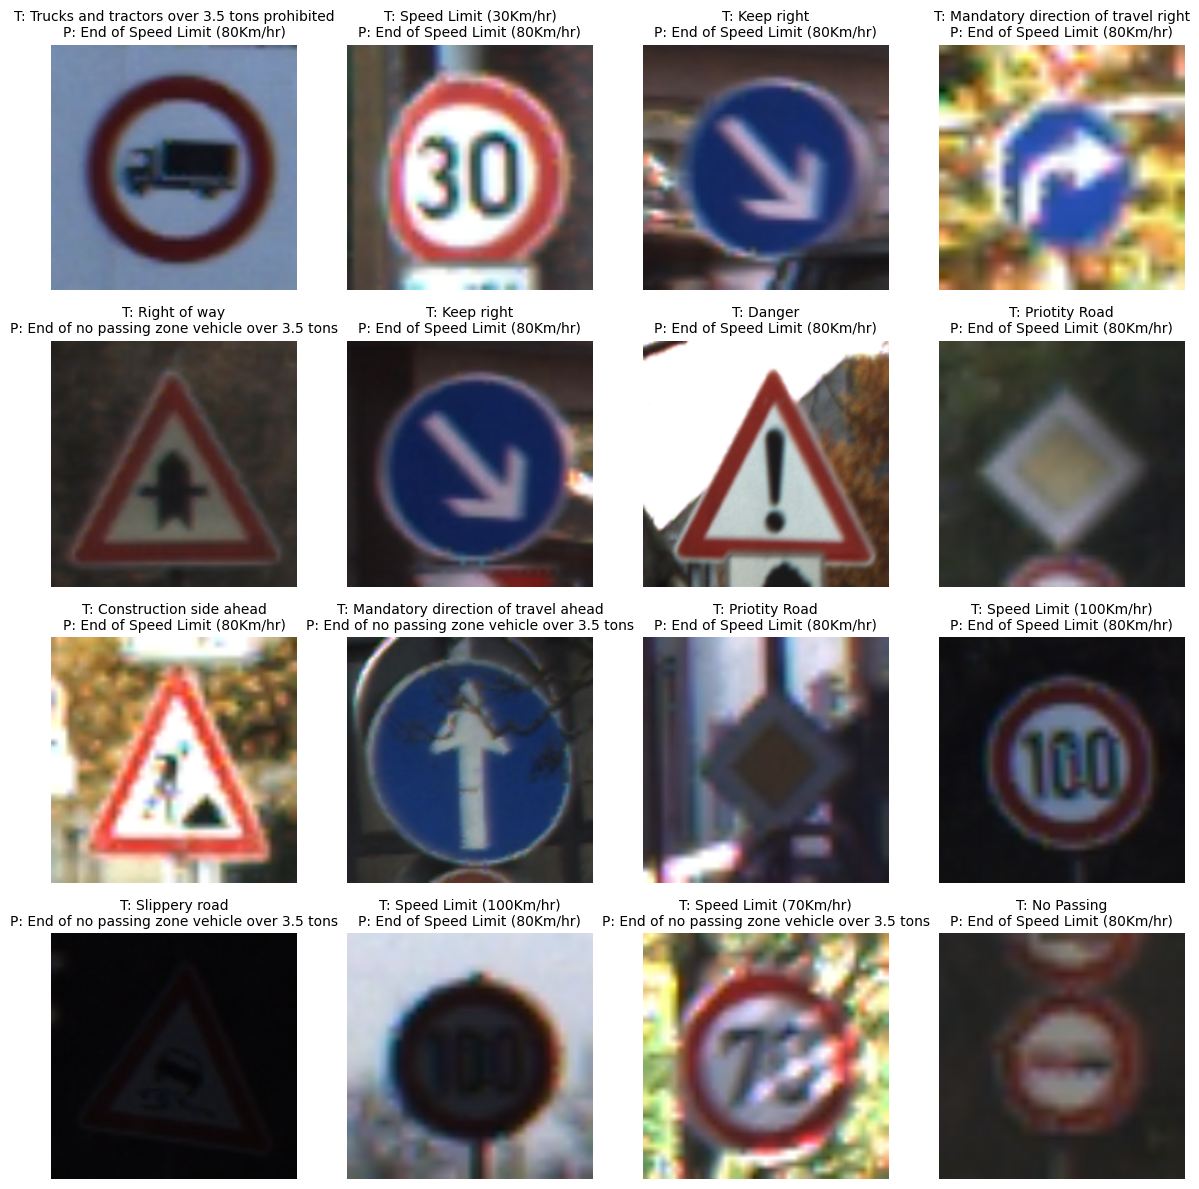

In [83]:
show_misclassified(model_resnet18, test_loader, device, class_names)

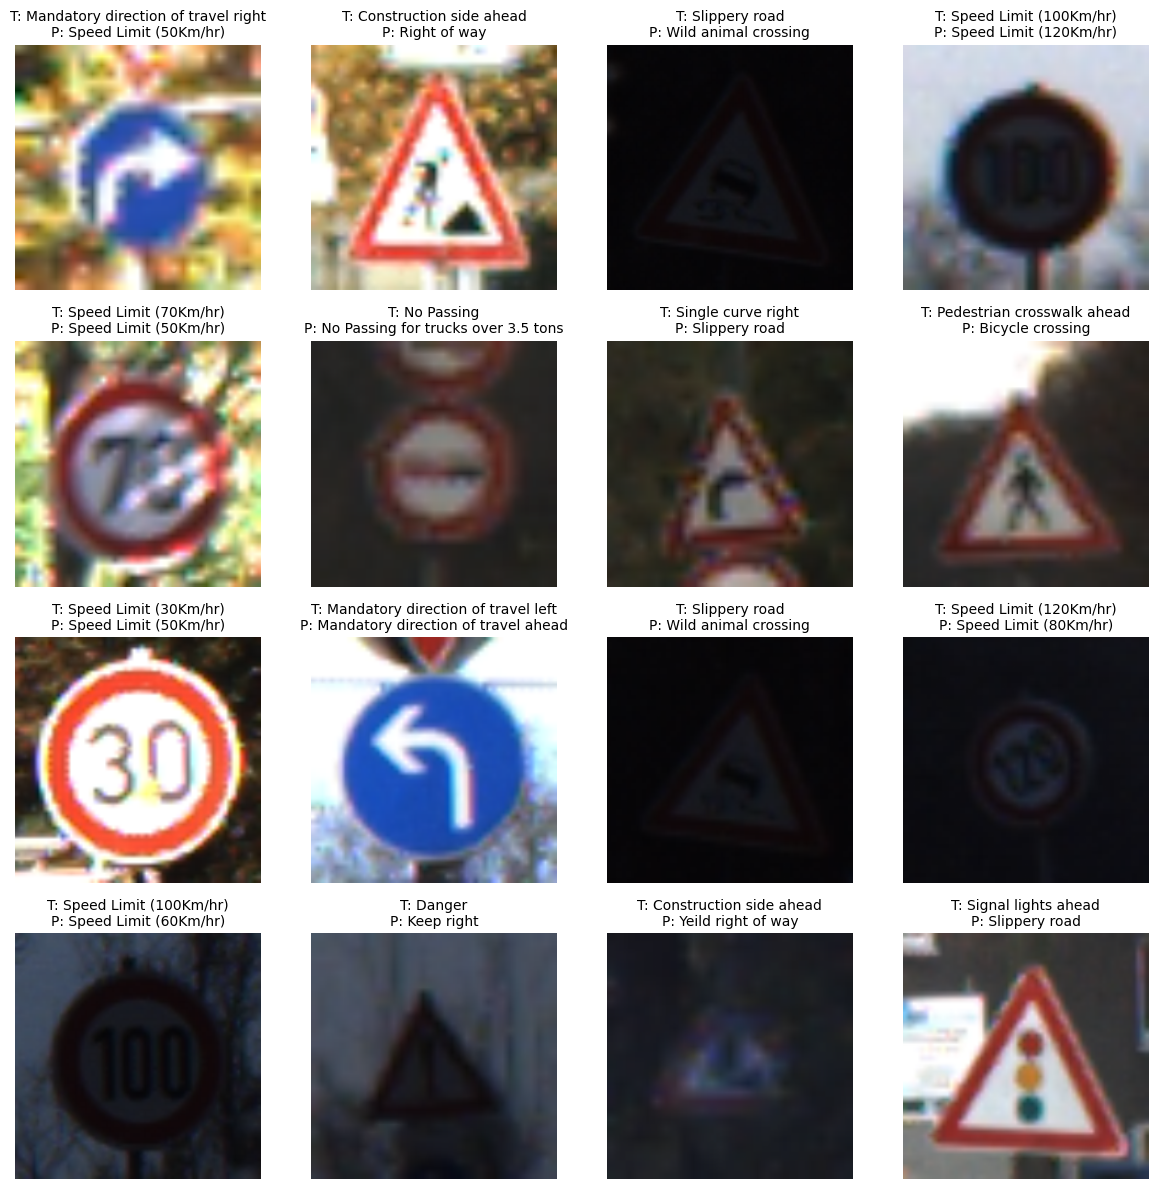

In [84]:
show_misclassified(model_eff, test_loader, device, class_names)

In [85]:
both_correct = (y_pred_eff == y_true) & (y_pred_res == y_true)
eff_only     = (y_pred_eff == y_true) & (y_pred_res != y_true)
res_only     = (y_pred_eff != y_true) & (y_pred_res == y_true)
both_wrong   = (y_pred_eff != y_true) & (y_pred_res != y_true)

print(f"Samples both correct:    {both_correct.sum()}")
print(f"EfficientNet only right: {eff_only.sum()}")
print(f"ResNet18 only right:     {res_only.sum()}")
print(f"Both wrong:              {both_wrong.sum()}")

Samples both correct:    7347
EfficientNet only right: 2018
ResNet18 only right:     1287
Both wrong:              1978


In [27]:
def measure_latency(model, dataloader, n_batches=10):
    model.eval()
    model.to(device)
    times = []
    
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= n_batches:
                break
            
            images = images.to(device)
            
            # Single timing measurement
            start = time.perf_counter()
            _ = model(images)
            if device.type == "cuda":
                torch.cuda.synchronize()
            end = time.perf_counter()
            
            times.append((end - start) / images.size(0))
    
    return torch.tensor(times).mean(), torch.tensor(times).std()

# effnet and resnet
mean_eff, std_eff = measure_latency(model_eff, test_loader)
mean_res, std_res = measure_latency(model_resnet18, test_loader)

print(f"EfficientNet: {mean_eff*1000:.2f} ± {std_eff*1000:.2f} ms / image")
print(f"ResNet18:     {mean_res*1000:.2f} ± {std_res*1000:.2f} ms / image")

EfficientNet: 29.52 ± 3.15 ms / image
ResNet18:     33.29 ± 2.95 ms / image


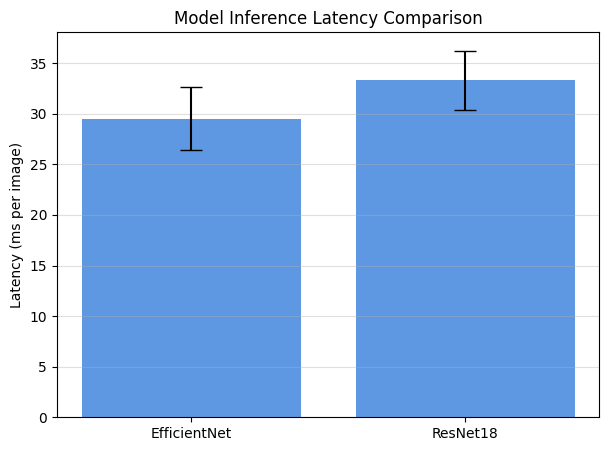

In [50]:
# Latency values (in ms)
nn_models = ["EfficientNet", "ResNet18"]
means = [mean_eff*1000, mean_res*1000]
stds = [std_eff*1000, std_res*1000]

plt.figure(figsize=(7,5))
plt.bar(nn_models, means, yerr=stds, capsize=8, color='#5F98E2')
plt.ylabel("Latency (ms per image)")
plt.title("Model Inference Latency Comparison")
plt.grid(axis='y', alpha=0.4)

plt.show()